# Gaussian Process Algorithm from Scratch

In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import cholesky, cho_solve
import sys
sys.path.insert(0,'/Users/eman/Documents/code_projects/kernellib/')
from kernellib.kernels import ard_kernel
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Training data is 11 points in [0,1] inclusive regularly spaced# Traini 
x_train = np.linspace(0, 1, 11).reshape(-1, 1)
# True function is sin(2*pi*x) with Gaussian noise
y_train = np.sin(x_train * (2 * np.pi)) + np.random.randn(x_train.shape[0], 1) * 0.2
y_train = np.squeeze(y_train)

x_test = np.linspace(0, 1, 51).reshape(-1, 1)
print(x_train.shape, y_train.shape, x_test.shape)

(11, 1) (11,) (51, 1)


In [7]:
kernel = 'rbf'
jitter = 1e-9
random_state = 123

init_signal_variance = 1.0
init_length_scale = 1.0
init_likelihood_variance = 0.1

theta0 = np.array([init_signal_variance, 
                   init_likelihood_variance, 
                   init_likelihood_variance])
bounds = ((1e-7, 1e7), (1e-7, 1e7), (1e-7, 1e7))


In [22]:
from sklearn.gaussian_process.kernels import _check_length_scale
from scipy.spatial.distance import pdist, cdist, squareform

def ard_kernel(X, Y=None, length_scale=None, eval_gradient=False):
    
    # Determine if the kernel is isotropic or not
    anisotropic = np.iterable(length_scale) and len(length_scale) > 1
    
    X = np.atleast_2d(X)
    length_scale = _check_length_scale(X, length_scale)
    
    if Y is None:
        dists = pdist(X / length_scale, metric='sqeuclidean')
        K = np.exp(-.5 * dists)
        # convert from upper-triangular matrix to square matrix
        K = squareform(K)
        np.fill_diagonal(K, 1)
    else:
        if eval_gradient:
            raise ValueError(
                "Gradient can only be evaluated when Y is None.")
        dists = cdist(X / length_scale, Y / length_scale,
                      metric='sqeuclidean')
        K = np.exp(-.5 * dists)

    if eval_gradient:

        if not anisotropic or length_scale.shape[0] == 1:
            K_gradient = \
                (K * squareform(dists))[:, :, np.newaxis]
            return K, K_gradient
        elif anisotropic:
            # We need to recompute the pairwise dimension-wise distances
            K_gradient = (X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2 \
                / (length_scale ** 2)
            K_gradient *= K[..., np.newaxis]
            return K, K_gradient
    else:
        return K

In [19]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import fmin_l_bfgs_b
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.utils.validation import check_X_y, check_array
from sklearn.gaussian_process.kernels import (_check_length_scale, 
                                              RBF, WhiteKernel, ConstantKernel)
from scipy.spatial.distance import pdist, cdist, squareform

class GaussianProcessRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, kernel='rbf', jitter=1e-10, random_state=None):

        self.kernel = kernel
        self.jitter = jitter
        self.random_state = random_state

        # Initialize heuristics
        self.signal_variance = 1.0
        self.likelihood_variance = 0.1

    def fit(self, X, y):

        # Check inputs
        X, y = check_X_y(X, y)

        self.X_train_ = X
        self.y_train_ = y
        
        # Determine Length_scale type
        if self.kernel == 'rbf':
            init_length_scale = 1.0
        elif self.kernel == 'ard':
            init_length_scale = np.ones(X.shape[1])
        else:
            raise ValueError('Unrecognised kernel.')
            
        # Initial HyperParameters
        theta0 = np.array([self.signal_variance,
                           self.likelihood_variance,
                           init_length_scale])

        bounds = ((1e-5, 1e5), (1e-5, 1e5), (1e-5, 1e5))

        # Gradient Descent (Negative Log Marginal Likelihood)
        best_params = minimize(self.neg_log_marginal_likelihood, 
                               x0=theta0, args=(), method='L-BFGS-B', 
                               bounds=bounds, jac=True)
        print(best_params)
        # Get the best parameters
        self.signal_variance, self.length_scale, self.likelihood_variance = \
            self._get_hyperparams(best_params.x)

        self.best_neg_log_likelihood = best_params.fun
        self.marginal_likelihood = np.exp(-best_params.fun)

        # Precompute Prediction quantities
        print(self.length_scale, self.signal_variance, self.likelihood_variance)
        
        self.kernel_ = self.set_kernel(length_scale=self.length_scale,
                                       signal_variance=self.signal_variance,
                                       likelihood_variance=self.likelihood_variance)
        
        K = self.kernel_(self.X_train_)
        
        K[np.diag_indices_from(K)] += self.jitter
        
        
        self.L_ = cholesky(K, lower=True)
        
        if self.y_train_.ndim == 1:
            y_train = self.y_train_[:, np.newaxis]
        
        self.weights_ = cho_solve((self.L_, True), y_train.squeeze())
        
        return self
    
    def set_kernel(self, length_scale=None, 
                   signal_variance=None, 
                   likelihood_variance=None):
        # Determine Kernel Type
        if hasattr(self, 'length_scale'):
            length_scale = self.length_scale
        elif length_scale is None:
            length_scale = 1.0
        
        if hasattr(self, 'signal_variance'):
            signal_variance = self.signal_variance  
        elif signal_variance is None:
            signal_variance = 1.0
        
        if hasattr(self, 'likelihood_variance'):
            likelihood_variance = self.likelihood_variance
        elif likelihood_variance is None:
            likelihood_variance = 0.1
            
        kernel = ConstantKernel(constant_value=signal_variance) \
                       * RBF(length_scale=length_scale) \
                       + WhiteKernel(noise_level=likelihood_variance)
        return kernel
    
    def K(self, X, Y=None, length_scale=1.0, signal_variance=1.0, 
          likelihood_variance=0.01, eval_gradient=False):
        """Standard Kernel
        
        K(x, x) = nu * exp(||x-y||^2) + noise * delta
        
        Parameters
        ----------
        X : array, (n_samples x d_dimensions)
        
        Y : array, (n_samples x 1)
        
        length_scale : float, array (1) or (d_dimensions)
        
        signal_variance : float
        
        likelihood_variance : float
        
        eval_gradient : bool
        
        Returns
        -------
        
        """
        kernel = ConstantKernel(constant_value=signal_variance) \
                 * RBF(length_scale=length_scale) \
                 + WhiteKernel(noise_level=likelihood_variance)
        
        if eval_gradient:
            return kernel(X, Y, eval_gradient=True)
        else:
            return kernel(X, Y)

    def predict(self, X, return_std=False, return_cov=False):
        
        X = check_array(X)
        
        if not hasattr(self, "X_train_"):
            raise ValueError('Not fitted yet...')
        
        K_trans = self.kernel_(X, self.X_train_)
        
        y_mean = np.dot(K_trans, self.weights_)
        
        if return_std:
            
            return y_mean, np.sqrt(self.predictive_variance(X, K_trans))
        
        elif return_cov:
            
            return y_mean, self.predictive_covariance(X, K_trans)
        
        else:
            return y_mean
    
    def predictive_covariance(self, X, K_trans=None):
        
        X = check_array(X)
        
        if K_trans is None:
            K_trans = self.kernel_(X, self.X_train_)
            
        v = cho_solve((self.L_, True), K_trans.T)
        
        covariance = self.kernel_(X) - np.dot(K_trans, v)
        
        return covariance
    
    def predictive_variance(self, X, K_trans=None):
        
        X = check_array(X)
        
        if K_trans is None:
            K_trans = self.kernel_(X, self.X_train_)
        
        # Compute K_inv of K from it's cholesky decomposition
        L_inv = solve_triangular(self.L_.T, np.eye(self.L_.shape[0]))
        K_inv = np.dot(L_inv, L_inv.T)
        
        # Compute variance of predictive distribution
        variance = self.kernel_.diag(X)
        variance -= np.einsum("ij,ij->i", np.dot(K_trans, K_inv), K_trans)
        
        # Check if any of the variances is negative because of
        # numerical issues. If yes: set the variance to 0.
        y_var_negative = variance < 0
        if np.any(y_var_negative):
            warnings.warn("Predicted variances smaller than 0. "
                          "Setting those variances to 0.")
            variance[y_var_negative] = 0.0        
        
        return variance

    def _get_hyperparams(self, theta):
        
        signal_variance = theta[0]
        likelihood_variance = theta[1]
        length_scale = theta[2:]
        
        return signal_variance, length_scale, likelihood_variance

    def neg_log_marginal_likelihood(self, theta):

        # Unpack theta parameters
        signal_variance, length_scale, likelihood_variance = \
            self._get_hyperparams(theta)

        # Get kernel
        K, K_gradient = self.K(x_train, 
                               length_scale=length_scale,
                               signal_variance=signal_variance,
                               likelihood_variance=likelihood_variance,
                               eval_gradient=True)

        # Add the jitter term
        K[np.diag_indices_from(K)] += self.jitter

        # Solve
        try:
            L = cholesky(K, lower=True)
        except np.linalg.LinAlgError:
            return -np.inf, np.zeros_like(theta)

        # multi-dimensional output of y_train
        y_train = self.y_train_
        
        if y_train.ndim == 1:
            y_train = y_train[:, np.newaxis]

        weights = cho_solve((L, True), y_train)

        # -----------------------------
        # Log likelihood
        # -----------------------------
        log_likelihood_dims = -0.5 * np.einsum("ik,ik->k", y_train, weights)
        log_likelihood_dims -= np.log(np.diag(L)).sum()
        log_likelihood_dims -= (K.shape[0] / 2) * np.log(2 * np.pi)
        log_likelihood = log_likelihood_dims.sum(-1)
        
        # ----------------------------
        # Log Likelihood Gradient
        # ----------------------------
        prefactor = np.einsum("ik,jk->ijk", weights, weights)
        prefactor -= cho_solve((L, True), np.eye(K.shape[0]))[:, :, np.newaxis]

        log_likelihood_gradient_dims = \
            0.5 * np.einsum("ijl,ijk->kl", prefactor, K_gradient)        
        log_likelihood_gradient = log_likelihood_gradient_dims.sum(-1)
        
        return -log_likelihood, -log_likelihood_gradient

In [20]:
gp_model = GaussianProcessRegressor(kernel='rbf')

gp_model.fit(x_train, y_train);
y_pred = gp_model.predict(x_test)
y_pred, y_err = gp_model.predict(x_test, return_std=True)


      fun: 18.10740633076854
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.4984654 ,   3.84428448, -11.02898512])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 21
      nit: 0
   status: 2
  success: False
        x: array([1. , 0.1, 1. ])
[1.] 1.0 0.1


In [21]:
def ax_plot_sklearn(ax, y_pred, title):
    
    # get the condifence intervals
    lower, upper = y_pred - y_err, y_pred + y_err
    # plot the training data
    ax.plot(x_train, y_train, 'r*')
    
    # plot the predictive mean
    ax.plot(x_test, y_pred, 'b')
    
    # plot the confidence bounds
    ax.fill_between(x_test.squeeze(), lower.squeeze(), upper.squeeze(), alpha=0.5, color='orange')
    
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
    ax.set_title(title)
    
    return None

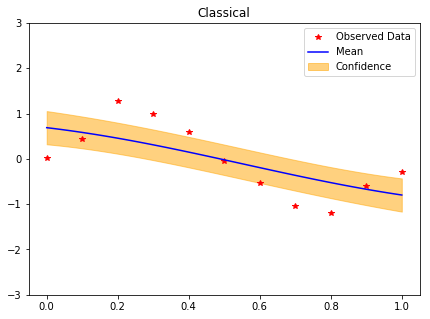

In [22]:
f, ax = plt.subplots(1, 1, figsize=(7,5))

ax_plot_sklearn(ax, y_pred, 'Classical')